In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score

from pymoo.operators.mutation.bitflip import BitflipMutation, Mutation
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.operators.sampling.rnd import BinaryRandomSampling, Sampling
from pymoo.operators.crossover.hux import HUX
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.indicators.hv import Hypervolume
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
import torch

from scipy.stats import ranksums

from joblib import Parallel, delayed
from pathlib import Path
from io import StringIO
import pandas as pd
import numpy as np
import pickle
import os
import re

import matplotlib.pyplot as plt

with open('data.pickle', 'rb') as fh:
	data_mapper = pickle.load(fh)

data_keys = list(data_mapper.keys())

In [17]:
class GenericOptimizer(Problem):
	population_size = 100
	n_neighbours = 5
	sequential = False
	def __init__(self, X_train, y_train, X_val, y_val, objectives, exec_mode):
		self.mutation_history = {}
		self.generation_number = 0

		self.exec_mode = exec_mode

		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		self.objectives = objectives

		super().__init__(
			n_var=self.n_instances,
			n_obj=len(objectives),               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):
		
		if self.exec_mode == "sequential":
			metrics = []
			for objective in self.objectives:
				metrics.append(self.eval_objective((objective, x)))
		else:
			metrics = Parallel(n_jobs=-1)(delayed(self.eval_objective)((objective, x)) for objective in self.objectives)
		
		self.generation_number += 1

		out["F"] = np.column_stack(metrics)

	def eval_objective(self, pack):
		objective, x = pack
			
		if "calculate_num_examples" in repr(objective):
			return GenericOptimizer.calculate_num_examples(x)

		elif "calculate_IR" in repr(objective):
			vals = []
			for instance in x:
				vals.append(GenericOptimizer.calculate_IR(self.y_train[instance]))
			return vals
		
		else:
			vals = []
			for instance in x:
				vals.append(objective(
					self.X_train[instance],
					self.y_train[instance],
					self.X_val,
					self.y_val,
					GenericOptimizer.n_neighbours
				))
			return vals

	@classmethod
	def calculate_IR(cls, y):
		df = pd.DataFrame(y).value_counts()
		return (df[1]/df[0]) if df.min() == 0 else (df[0]/df[1])
	
	@classmethod
	def filter_by_class(cls, x, y, label):
		indices = np.where(y==label)
		return x[indices], y[indices]
	
	@classmethod
	def calculate_overall_error(cls, x_train, y_train, x_val, y_val, n):
				
		num_included_instances = x_train.shape[0]

		if num_included_instances >= n:
			optimization_knn = KNeighborsClassifier(n_neighbors=n)
			optimization_knn.fit(x_train, y_train)

			y_pred = optimization_knn.predict(x_val)
			balanced_acc = accuracy_score(y_val, y_pred)
			return 1-balanced_acc
		else:
			return 1

	@classmethod
	def calculate_overall_classBalanced_error(cls, x_train, y_train, x_val, y_val, n):
				
		num_included_instances = x_train.shape[0]

		if num_included_instances >= n:
			optimization_knn = KNeighborsClassifier(n_neighbors=n)
			optimization_knn.fit(x_train, y_train)

			y_pred = optimization_knn.predict(x_val)
			acc = balanced_accuracy_score(y_val, y_pred)
			return 1-acc
		else:
			return 1
	
	@classmethod
	def calculate_mean_class_error(cls, x_train, y_train, x_val, y_val, n):
		errors = []
		for label in np.unique(y_val):
			label_x_val, label_y_val = cls.filter_by_class(x_val, y_val, label)
			errors.append(cls.calculate_overall_error(
				x_train,
				y_train,
				label_x_val,
				label_y_val,
				n
			))
		return np.mean(errors)
			
	@classmethod
	def calculate_class0_error(cls, x_train, y_train, x_val, y_val, n):
		class0_x_val, class0_y_val = cls.filter_by_class(x_val, y_val, 0)
		err = cls.calculate_overall_error(
			x_train,
			y_train,
			class0_x_val,
			class0_y_val,
			n
		)
		return err

	@classmethod
	def calculate_class1_error(cls, x_train, y_train, x_val, y_val, n):
		class1_x_val, class1_y_val = cls.filter_by_class(x_val, y_val, 1)
		err = cls.calculate_overall_error(
			x_train,
			y_train,
			class1_x_val,
			class1_y_val,
			n
		)
		return err

	@classmethod
	def calculate_overall_inverse_f1(cls, x_train, y_train, x_val, y_val, n):
				
		num_included_instances = x_train.shape[0]
		counts = pd.DataFrame(y_train).value_counts()
		if num_included_instances >= n:
			optimization_knn = KNeighborsClassifier(n_neighbors=n)
			optimization_knn.fit(x_train, y_train)

			y_pred = optimization_knn.predict(x_val)
			f1 = f1_score(y_val, y_pred, average='binary')
			return 1-f1
		else:
			return 1

	@classmethod
	def calculate_class0_inverse_f1(cls, x_train, y_train, x_val, y_val, n):
		class0_x_val, class0_y_val = cls.filter_by_class(x_val, y_val, 0)
		inv_f1 = cls.calculate_overall_inverse_f1(
			x_train,
			y_train,
			class0_x_val,
			class0_y_val,
			n
		)
		return inv_f1

	@classmethod
	def calculate_class1_inverse_f1(cls, x_train, y_train, x_val, y_val, n):
		class1_x_val, class1_y_val = cls.filter_by_class(x_val, y_val, 1)
		inv_f1 = cls.calculate_overall_inverse_f1(
			x_train,
			y_train,
			class1_x_val,
			class1_y_val,
			n
		)
		return inv_f1
	
	@classmethod
	def calculate_num_examples(cls, instances):
		return np.sum(instances, axis=1)

class DiverseCustomSampling(Sampling):
	def __init__(self):
		super().__init__()

	def _do(self, problem, n_samples, **kwargs):

		target_inclusions = np.random.randint(
			problem.n_var // 3,
			problem.n_var,
			n_samples
		)
		init_pops = []
		for target in target_inclusions:
			array = np.array([1]*target + [0]*(problem.n_var - target))
			np.random.shuffle(array)
			init_pops.append(array)
		init_pops = np.array(init_pops, dtype=np.bool)
		return init_pops

class BiasedBinarySampling(Sampling):
	def __init__(self, labels, major_prob, minor_prob):
		
		self.labels = labels
		counts = pd.DataFrame(labels).value_counts()
		if counts[0] > counts[1]:
			self.c0_thresh = major_prob
			self.c1_thresh = minor_prob
		else:
			self.c0_thresh = minor_prob
			self.c1_thresh = major_prob

		super().__init__()

	def _do(self, problem, n_samples, **kwargs):

		rands = np.random.random((n_samples, problem.n_var))
		init_pops = np.zeros((n_samples, problem.n_var), dtype=bool)
		for idx, label in enumerate(self.labels):
			if label == 0:
				init_pops[:, idx] = (rands[:, idx] < self.c0_thresh).astype(bool)
			if label == 1:
				init_pops[:, idx] = (rands[:, idx] < self.c1_thresh).astype(bool)


		return init_pops

def over_sample(x, y):
	counts = pd.DataFrame(y).value_counts()
	minority_class_label = counts.index[np.argmin(counts)][0]
	minority_class_indicies = np.where(y == minority_class_label)[0]
	# y = y.reshape(-1, 1)
	over_sampled_x = np.concatenate((x, x[minority_class_indicies]), axis=0)
	over_sampled_y = np.concatenate((y, y[minority_class_indicies]), axis=0)
	# over_sampled_y = over_sampled_y.reshape(-1)    
	return over_sampled_x, over_sampled_y

def GA_optimize(x_train, y_train, x_validation, y_valiation):
	problem = GenericOptimizer(
		x_train,
		y_train,
		x_validation,
		y_valiation,
		[GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error],
		"sequential"
	)
	algorithm = NSGA2(
		pop_size=GenericOptimizer.population_size, 
		sampling=DiverseCustomSampling(),
		crossover=HUX(), 
		mutation=BitflipMutation(), 
		eliminate_duplicates=True,
	)
	result = minimize(
		problem, 
		algorithm, 
		('n_gen', GenericOptimizer.population_size), # <--- maybe increase
		save_history=False
	)
	  
	return result

def execute(data_key):
	save_name = f"results/{data_key} VAE.pickle"

	if os.path.exists(save_name):
		return None, data_key
	
	try:
		problem = GenericOptimizer(
			data_mapper[data_key]['x_train'], 
			data_mapper[data_key]['y_train'], 
			data_mapper[data_key]['x_validation'], 
			data_mapper[data_key]['y_validation'], 
			[GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error],
			"sequential"
		)
		algorithm = NSGA2(
			pop_size=GenericOptimizer.population_size, 
			sampling=DiverseCustomSampling(),
			crossover=HUX(), 
			mutation=BitflipMutation(), 
			eliminate_duplicates=True,
		)
		result = minimize(
			problem, 
			algorithm, 
			('n_gen', GenericOptimizer.population_size),
			save_history=False
		)
		return result, data_key
	except:
		return None, data_key

def parallel_error(instance, x_train, y_train, x_compare, y_compare):

	x_filtered, y_filtered = x_train[instance], y_train[instance]
	if x_filtered.shape[0] < GenericOptimizer.n_neighbours: 
		error = 1
	else:
		knn = KNeighborsClassifier(n_neighbors=GenericOptimizer.n_neighbours)
		knn.fit(x_filtered, y_filtered)
		y_pred = knn.predict(x_compare)
		error = 1 - accuracy_score(y_compare, y_pred)
	return error

# for result, data_key in Parallel(n_jobs=-1, return_as='generator')(delayed(execute)(data_key) for data_key in data_mapper):
# 	if result is not None:
# 		with open(os.path.join("results", f'{data_key} VAE.pickle'), 'wb') as fh:
# 			pickle.dump(result, fh)
# 			print(f'Saved {data_key} VAE.pickle')
# 	else:
# 		print(f'Passed {data_key} VAE.pickle')

## Generate regular sample

In [ ]:
def execute(package):
	data_key, run_type = package
	save_name = f"results/{data_key} {run_type}.pickle"

	if os.path.exists(save_name): return None, data_key
	
	try:
		problem = GenericOptimizer(
			data_mapper[data_key]['x_train'], data_mapper[data_key]['y_train'], 
			data_mapper[data_key]['x_validation'], data_mapper[data_key]['y_validation'], 
			[GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error],
			"sequential"
		)
		algorithm = NSGA2(
			pop_size=GenericOptimizer.population_size, 
			sampling=BinaryRandomSampling(),
			crossover=HUX(), 
			mutation=BitflipMutation(), 
			eliminate_duplicates=True,
		)
		result = minimize(
			problem, 
			algorithm, 
			('n_gen', GenericOptimizer.population_size),
			save_history=True
		)
		return result, data_key
	except:
		return None, data_key
	
run_type = "randomPopulation"
n_jobs = 8
for result, data_key in Parallel(n_jobs=n_jobs, return_as='generator')(delayed(execute)((data_key, run_type)) for data_key in data_mapper):
	if result is not None:
		with open(os.path.join("results", f'{data_key} {run_type}.pickle'), 'wb') as fh:
			pickle.dump(result, fh)
			print(f'Saved {data_key} {run_type}.pickle')
			del result

	else:
		print(f'Passed {data_key} {run_type}.pickle')

In [ ]:
def execute(package):
	data_key, run_type = package
	save_name = f"results/{data_key} {run_type}.pickle"

	if os.path.exists(save_name): return None, data_key
	
	try:
		problem = GenericOptimizer(
			data_mapper[data_key]['x_train'], data_mapper[data_key]['y_train'], 
			data_mapper[data_key]['x_validation'], data_mapper[data_key]['y_validation'], 
			[GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error],
			"sequential"
		)
		algorithm = NSGA2(
			pop_size=GenericOptimizer.population_size, 
			sampling=BiasedBinarySampling(data_mapper[data_key]['y_train'], 0.3, 0.7),
			crossover=HUX(), 
			mutation=BitflipMutation(), 
			eliminate_duplicates=True,
		)
		result = minimize(
			problem, 
			algorithm, 
			('n_gen', GenericOptimizer.population_size),
			save_history=True
		)
		return result, data_key
	except:
		return None, data_key
	
run_type = "biasedPopulation"
n_jobs = 8
for result, data_key in Parallel(n_jobs=n_jobs, return_as='generator')(delayed(execute)((data_key, run_type)) for data_key in data_mapper):
	if result is not None:
		with open(os.path.join("results", f'{data_key} {run_type}.pickle'), 'wb') as fh:
			pickle.dump(result, fh)
			print(f'Saved {data_key} {run_type}.pickle')
			del result

	else:
		print(f'Passed {data_key} {run_type}.pickle')

In [ ]:
def execute(package):
	data_key, run_type = package
	save_name = f"results/{data_key} {run_type}.pickle"

	if os.path.exists(save_name): return None, data_key
	
	try:
		problem = GenericOptimizer(
			data_mapper[data_key]['x_train'], data_mapper[data_key]['y_train'], 
			data_mapper[data_key]['x_validation'], data_mapper[data_key]['y_validation'], 
			[GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error],
			"sequential"
		)
		algorithm = NSGA2(
			pop_size=GenericOptimizer.population_size, 
			sampling=DiverseCustomSampling(),
			crossover=HUX(), 
			mutation=BitflipMutation(), 
			eliminate_duplicates=True,
		)
		result = minimize(
			problem, 
			algorithm, 
			('n_gen', GenericOptimizer.population_size),
			save_history=True
		)
		return result, data_key
	except:
		return None, data_key
	
run_type = "diversePopulation"
n_jobs = 8
for result, data_key in Parallel(n_jobs=n_jobs, return_as='generator')(delayed(execute)((data_key, run_type)) for data_key in data_mapper):
	if result is not None:
		with open(os.path.join("results", f'{data_key} {run_type}.pickle'), 'wb') as fh:
			pickle.dump(result, fh)
			print(f'Saved {data_key} {run_type}.pickle')
			del result
	else:
		print(f'Passed {data_key} {run_type}.pickle')

# Oversample

In [ ]:
def execute(package):
	data_key, run_type = package
	save_name = f"results/{data_key} {run_type}.pickle"
	if os.path.exists(save_name): return None, data_key
	
	try:
		x_train, y_train = over_sample(
			data_mapper[data_key]['x_train'],
			data_mapper[data_key]['y_train']
		)
		problem = GenericOptimizer(
			x_train, y_train, 
			data_mapper[data_key]['x_validation'], data_mapper[data_key]['y_validation'], 
			[GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error],
			"sequential"
		)
		algorithm = NSGA2(
			pop_size=GenericOptimizer.population_size, 
			sampling=BinaryRandomSampling(),
			crossover=HUX(), 
			mutation=BitflipMutation(), 
			eliminate_duplicates=True,
		)
		result = minimize(
			problem, 
			algorithm, 
			('n_gen', GenericOptimizer.population_size),
			save_history=True
		)
		return result, data_key
	except:
		return None, data_key
	
run_type = "randomPopulation overSample"
n_jobs = 8
for result, data_key in Parallel(n_jobs=n_jobs, return_as='generator')(delayed(execute)((data_key, run_type)) for data_key in data_mapper):
	if result is not None:
		with open(os.path.join("results", f'{data_key} {run_type}.pickle'), 'wb') as fh:
			pickle.dump(result, fh)
			print(f'Saved {data_key} {run_type}.pickle')
			del result

	else:
		print(f'Passed {data_key} {run_type}.pickle')

# ----------------------------------

def execute(package):
	data_key, run_type = package
	save_name = f"results/{data_key} {run_type}.pickle"
	if os.path.exists(save_name): return None, data_key	
	try:
		x_train, y_train = over_sample(
			data_mapper[data_key]['x_train'],
			data_mapper[data_key]['y_train']
		)
		problem = GenericOptimizer(
			x_train, y_train, 
			data_mapper[data_key]['x_validation'], data_mapper[data_key]['y_validation'], 
			[GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error],
			"sequential"
		)
		algorithm = NSGA2(
			pop_size=GenericOptimizer.population_size, 
			sampling=BiasedBinarySampling(data_mapper[data_key]['y_train'], 0.3, 0.7),
			crossover=HUX(), 
			mutation=BitflipMutation(), 
			eliminate_duplicates=True,
		)
		result = minimize(
			problem, 
			algorithm, 
			('n_gen', GenericOptimizer.population_size),
			save_history=True
		)
		return result, data_key
	except:
		return None, data_key
	
run_type = "biasedPopulation overSample"
n_jobs = 8
for result, data_key in Parallel(n_jobs=n_jobs, return_as='generator')(delayed(execute)((data_key, run_type)) for data_key in data_mapper):
	if result is not None:
		with open(os.path.join("results", f'{data_key} {run_type}.pickle'), 'wb') as fh:
			pickle.dump(result, fh)
			print(f'Saved {data_key} {run_type}.pickle')
			del result
	else:
		print(f'Passed {data_key} {run_type}.pickle')

# ----------------------------

def execute(package):
	data_key, run_type = package
	save_name = f"results/{data_key} {run_type}.pickle"
	if os.path.exists(save_name): return None, data_key
	try:
		x_train, y_train = over_sample(
			data_mapper[data_key]['x_train'],
			data_mapper[data_key]['y_train']
		)
		problem = GenericOptimizer(
			x_train, y_train, 
			data_mapper[data_key]['x_validation'], data_mapper[data_key]['y_validation'], 
			[GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error],
			"sequential"
		)
		algorithm = NSGA2(
			pop_size=GenericOptimizer.population_size, 
			sampling=DiverseCustomSampling(),
			crossover=HUX(), 
			mutation=BitflipMutation(), 
			eliminate_duplicates=True,
		)
		result = minimize(
			problem, 
			algorithm, 
			('n_gen', GenericOptimizer.population_size),
			save_history=True
		)
		return result, data_key
	except:
		return None, data_key
	
run_type = "diversePopulation overSample"
n_jobs = 8
for result, data_key in Parallel(n_jobs=n_jobs, return_as='generator')(delayed(execute)((data_key, run_type)) for data_key in data_mapper):
	if result is not None:
		with open(os.path.join("results", f'{data_key} {run_type}.pickle'), 'wb') as fh:
			pickle.dump(result, fh)
			print(f'Saved {data_key} {run_type}.pickle')
			del result
	else:
		print(f'Passed {data_key} {run_type}.pickle')

Passed 0_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 1_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 2_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 3_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 4_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 5_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 6_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 7_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 8_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 9_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 10_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 11_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 12_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 13_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 14_abalone-20_vs_8-9-10 randomPopulation overSample.pickle
Passed 15_abalone-20

# Aggregation

In [ ]:
diffs = []
for data_key in data_mapper:
	x_train = data_mapper[data_key]['x_train']
	y_train = data_mapper[data_key]['y_train']
	oversampled_x_train, oversampled_y_train = over_sample(x_train, y_train)

	diffs.append(len(oversampled_x_train) - len(x_train))
np.min(diffs), np.max(diffs), np.median(diffs)

(np.int64(2), np.int64(134), np.float64(14.0))

In [ ]:
def compare_data_key_reg_sample_versus_over_sample(data_key, sample_type):
	if os.path.exists(f'results/{data_key} {sample_type}.pickle') is False: return data_key, None, None

	x_train = data_mapper[data_key]['x_train']
	y_train = data_mapper[data_key]['y_train']
	oversampled_x_train, oversampled_y_train = over_sample(x_train, y_train)

	x_test = data_mapper[data_key]['x_test']
	y_test = data_mapper[data_key]['y_test']

	#########################################################
	#########################################################
	#########################################################
	
	file = f'results/{data_key} {sample_type}.pickle'
	pareto_indices = NonDominatedSorting().do(result_storage[file])[-1]
	pareto_instances = result_storage[file][pareto_indices]

	# test_F = Parallel(n_jobs=-1)(delayed(parallel_error)(instance, x_train, y_train, x_test, y_test) for instance in pareto_instances)
	test_F = []
	for instance in pareto_instances:
		x_filtered, y_filtered = x_train[instance], y_train[instance]
		if x_filtered.shape[0] < GenericOptimizer.n_neighbours: 
			error = 1
		else:
			knn = KNeighborsClassifier(n_neighbors=GenericOptimizer.n_neighbours)
			knn.fit(x_filtered, y_filtered)
			y_pred = knn.predict(x_test)
			error = 1 - accuracy_score(y_test, y_pred)
		test_F.append(error)

	ideal_test = pareto_instances[np.argmin(test_F)]
	ideal_optimized_test_err = GenericOptimizer.calculate_overall_error(
		x_train[ideal_test],
		y_train[ideal_test],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)

	#########################################################
	#########################################################
	#########################################################

	file = f'results/{data_key} {sample_type} overSample.pickle'
	pareto_indices = NonDominatedSorting().do(result_storage[file])[-1]
	pareto_instances = result_storage[file][pareto_indices]
	
	# test_F = Parallel(n_jobs=-1)(delayed(parallel_error)(instance, oversampled_x_train, oversampled_y_train, x_test, y_test) for instance in pareto_instances)
	test_F = []
	for instance in pareto_instances:
		x_filtered, y_filtered = oversampled_x_train[instance], oversampled_y_train[instance]
		if x_filtered.shape[0] < GenericOptimizer.n_neighbours: 
			error = 1
		else:
			knn = KNeighborsClassifier(n_neighbors=GenericOptimizer.n_neighbours)
			knn.fit(x_filtered, y_filtered)
			y_pred = knn.predict(x_test)
			error = 1 - accuracy_score(y_test, y_pred)
		test_F.append(error)

	ideal_test = pareto_instances[np.argmin(test_F)]
	ideal_optimized_test_err_oversample = GenericOptimizer.calculate_overall_error(
		oversampled_x_train[ideal_test],
		oversampled_y_train[ideal_test],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)

	return data_key, ideal_optimized_test_err_oversample, ideal_optimized_test_err

results_by_sampling = {}

chunk_size = 75
for start_idx in range(0, len(data_mapper.keys())-1, chunk_size):
	end_idx = min(len(data_mapper.keys())-1, start_idx + chunk_size)

	result_storage = {}
	for data_key in list(data_mapper.keys())[start_idx:end_idx]:
		for sample_type in ['biasedPopulation', 'randomPopulation', 'diversePopulation']:
			
			results_by_sampling[data_key] = {}

			file = f'results/{data_key} {sample_type}.pickle'
			if os.path.exists(file) is False: continue

			with open(file, "rb") as fh:
				result = pickle.load(fh)
			result_storage[file] = result.X

			file = f'results/{data_key} {sample_type} overSample.pickle'
			if os.path.exists(file) is False: continue
			with open(file, "rb") as fh:
				result = pickle.load(fh)
			result_storage[file] = result.X

	print("Done loading..")

	for sample_type in ['biasedPopulation', 'randomPopulation', 'diversePopulation']:
		for data_key, over_sample_err, regular_sample_err in Parallel(n_jobs=-1)(delayed(compare_data_key_reg_sample_versus_over_sample)(data_key, sample_type) for data_key in list(data_mapper.keys())[start_idx:end_idx]):
			results_by_sampling[data_key][sample_type] = (over_sample_err, regular_sample_err)


		print(f"Done calculating... {len(list(data_mapper.keys())[start_idx:end_idx])}")
	# for data_key in list(data_mapper.keys())[start_idx:end_idx]:
		
		# for sample_type, over_sample_better in Parallel(n_jobs=3)(delayed(compare_data_key_reg_sample_versus_over_sample)(data_key, sample_type) for sample_type in ['biasedPopulation', 'randomPopulation', 'diversePopulation']):
		# 	results_by_sampling[data_key][sample_type] = over_sample_better

		# for sample_type in ['biasedPopulation', 'randomPopulation', 'diversePopulation']:
		# 	over_sample_better = compare_data_key_reg_sample_versus_over_sample(data_key, sample_type)
		# 	results_by_sampling[data_key][sample_type] = over_sample_better
	del result_storage


In [18]:
datakey_mappings = {}
sampling_types = ['biasedPopulation', 'randomPopulation', 'diversePopulation']
for data_key in results_by_sampling:
	dataset_name = "_".join(data_key.split("_")[1:])
	iter_num = data_key.split("_")[0]
	if dataset_name not in datakey_mappings:
		datakey_mappings[dataset_name] = {}
	datakey_mappings[dataset_name][iter_num] = data_key

In [19]:
baseline_validation_error = {}
baseline_test_error = {}

c0_validation_error = {}
c1_validation_error = {}
c0_test_error = {}
c1_test_error = {}

for dataset_name in datakey_mappings:
	for iter_num in datakey_mappings[dataset_name]:
		if "zoo" in dataset_name: continue
		
		data_key = f"{iter_num}_{dataset_name}"
		
		x_train = data_mapper[data_key]['x_train']
		y_train = data_mapper[data_key]['y_train']
		
		x_validation = data_mapper[data_key]['x_validation']
		y_validation = data_mapper[data_key]['y_validation']

		x_test = data_mapper[data_key]['x_test']
		y_test = data_mapper[data_key]['y_test']

		baseline_validation_error[data_key] = GenericOptimizer.calculate_overall_error(
			x_train,
			y_train,
			x_validation,
			y_validation,
			GenericOptimizer.n_neighbours
		)
		baseline_test_error[data_key] = GenericOptimizer.calculate_overall_error(
			x_train,
			y_train,
			x_test,
			y_test,
			GenericOptimizer.n_neighbours
		)

		c0_validation_error[data_key] = GenericOptimizer.calculate_class0_error(
			x_train,
			y_train,
			x_validation,
			y_validation,
			GenericOptimizer.n_neighbours
		)	
		c1_validation_error[data_key] = GenericOptimizer.calculate_class1_error(
			x_train,
			y_train,
			x_validation,
			y_validation,
			GenericOptimizer.n_neighbours
		)	
		c0_test_error[data_key] = GenericOptimizer.calculate_class0_error(
			x_train,
			y_train,
			x_test,
			y_test,
			GenericOptimizer.n_neighbours
		)	
		c1_test_error[data_key] = GenericOptimizer.calculate_class1_error(
			x_train,
			y_train,
			x_test,
			y_test,
			GenericOptimizer.n_neighbours
		)	
		

In [20]:
def aggregate_function(data_key, sample_type):
	if os.path.exists(f'results/{data_key} {sample_type}.pickle') is False: return data_key, None

	x_train = data_mapper[data_key]['x_train']
	y_train = data_mapper[data_key]['y_train']

	# oversampled_x_train, oversampled_y_train = over_sample(x_train, y_train)

	x_validation = data_mapper[data_key]['x_validation']
	y_validation = data_mapper[data_key]['y_validation']

	x_test = data_mapper[data_key]['x_test']
	y_test = data_mapper[data_key]['y_test']

	file = f'results/{data_key} {sample_type}.pickle'
	pareto_indices = NonDominatedSorting().do(result_storage[file])[-1]
	pareto_instances = result_storage[file][pareto_indices]

	#########################################################
	#########################################################
	#########################################################
	
	validation_F = Parallel(n_jobs=-1)(delayed(parallel_error)(instance, x_train, y_train, x_validation, y_validation) for instance in pareto_instances)
	ideal_validation = pareto_instances[np.argmin(validation_F)]
	ideal_optimized_validation_err = GenericOptimizer.calculate_overall_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_validation,
		y_validation,
		GenericOptimizer.n_neighbours
	)
	optimized_test_err = GenericOptimizer.calculate_overall_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)

	c0_validation_error = GenericOptimizer.calculate_class0_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_validation,
		y_validation,
		GenericOptimizer.n_neighbours
	)	
	c1_validation_error = GenericOptimizer.calculate_class1_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_validation,
		y_validation,
		GenericOptimizer.n_neighbours
	)	
	c0_test_error = GenericOptimizer.calculate_class0_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)	
	c1_test_error = GenericOptimizer.calculate_class1_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)	

	#########################################################
	#########################################################
	#########################################################

	test_F = Parallel(n_jobs=-1)(delayed(parallel_error)(instance, x_train, y_train, x_test, y_test) for instance in pareto_instances)
	ideal_test = pareto_instances[np.argmin(test_F)]
	ideal_optimized_test_err = GenericOptimizer.calculate_overall_error(
		x_train[ideal_test],
		y_train[ideal_test],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)

	ideal_c0_test_error = GenericOptimizer.calculate_class0_error(
		x_train[ideal_test],
		y_train[ideal_test],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)	
	ideal_c1_test_error = GenericOptimizer.calculate_class1_error(
		x_train[ideal_test],
		y_train[ideal_test],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)	
	#########################################################
	#########################################################
	#########################################################

	total_samples = x_train.shape[0]
	validation_samples = np.sum(ideal_validation)
	test_samples = np.sum(ideal_test)
	record = {
		"Ideal validation error": ideal_optimized_validation_err,
		"Optimized test error": optimized_test_err,
		"Ideal optimized test error": ideal_optimized_test_err,
		"Class 0 validation error": c0_validation_error,
		"Class 1 validation error": c1_validation_error,
		"Class 0 test error": c0_test_error,
		"Class 1 test error": c1_test_error,
		"Class 0 ideal test error": ideal_c0_test_error,
		"Class 1 ideal test error": ideal_c1_test_error,
		"Validation reduction rate": round((total_samples-validation_samples)/total_samples, 2),
		"Test reduction rate": round((total_samples-test_samples)/total_samples, 2),
	}

	return data_key, record

results_by_sampling = {}

chunk_size = 75
for start_idx in range(0, len(data_mapper.keys())-1, chunk_size):
	end_idx = min(len(data_mapper.keys())-1, start_idx + chunk_size)

	result_storage = {}
	for data_key in list(data_mapper.keys())[start_idx:end_idx]:
		for sample_type in ['biasedPopulation', 'randomPopulation', 'diversePopulation']:
			
			results_by_sampling[data_key] = {}

			file = f'results/{data_key} {sample_type}.pickle'
			if os.path.exists(file) is False: continue

			with open(file, "rb") as fh:
				result = pickle.load(fh)
			result_storage[file] = result.X

			file = f'results/{data_key} {sample_type} overSample.pickle'
			if os.path.exists(file) is False: continue
			with open(file, "rb") as fh:
				result = pickle.load(fh)
			result_storage[file] = result.X

	print("Done loading..")

	for sample_type in ['biasedPopulation', 'randomPopulation', 'diversePopulation']:
		for data_key, record in Parallel(n_jobs=-1)(delayed(aggregate_function)(data_key, sample_type) for data_key in list(data_mapper.keys())[start_idx:end_idx]):
			results_by_sampling[data_key][sample_type] = record
		print(f"Done calculating... {len(list(data_mapper.keys())[start_idx:end_idx])}")
	del result_storage


Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 19
Done calculating... 19
Done calculating... 19


In [23]:
records = []
for sample_type in results_by_sampling[data_key]:
	for dataset_name in datakey_mappings:

		values = []
		
		validation_baseline = []
		test_baseline = []

		c0_val_baseline = []
		c1_val_baseline = []

		c0_test_baseline = []
		c1_test_baseline = []



		if "zoo" in dataset_name: continue

		execution_data = {

			"Optimized validation acc": [],
			"Optimized test acc": [],
			"Ideal test acc": [],

			"optimized class0 validation acc diff": [],
			"optimized class1 validation acc diff": [],

			"optimized class0 test acc diff": [],
			"optimized class1 test acc diff": [],

			"ideal class0 test acc diff": [],
			"ideal class1 test acc diff": [],

			"optimized class0 validation acc": [],
			"optimized class1 validation acc": [],

			"optimized class0 test acc": [],
			"optimized class1 test acc": [],

			"ideal class0 test acc": [],
			"ideal class1 test acc": [],

			"Optimized validation diff": [],
			"Optimized test diff": [],
			"Ideal test diff": [],

			"Validation IR": [],
			"Valdidation RR": [],

			"Test IR": [],
			"Test RR": []
		}
		for iter_num in datakey_mappings[dataset_name]:
			data_key = f"{iter_num}_{dataset_name}"		
			regular_sample_data = results_by_sampling[data_key][sample_type]

			y_train = data_mapper[data_key]['y_train']
			minority_label = 0 if pd.DataFrame(y_train).value_counts().min() == [pd.DataFrame(y_train).value_counts()[0]] else 1 
			
			execution_data['Optimized validation acc'].append(1 - regular_sample_data['Ideal validation error'])
			execution_data['Optimized test acc'].append(1 - regular_sample_data['Optimized test error'])
			execution_data['Ideal test acc'].append(1 - regular_sample_data['Ideal optimized test error'])

			execution_data['Valdidation RR'].append(regular_sample_data['Validation reduction rate'])
			execution_data['Test RR'].append(regular_sample_data['Test reduction rate'])

			test_baseline.append(1 - baseline_test_error[data_key])
			validation_baseline.append(1 - baseline_validation_error[data_key])

			execution_data['optimized class0 validation acc diff'].append(c0_validation_error[data_key] - regular_sample_data['Class 0 validation error'])
			execution_data['optimized class1 validation acc diff'].append(c1_validation_error[data_key] - regular_sample_data['Class 1 validation error'])

			execution_data['optimized class0 test acc diff'].append(c0_test_error[data_key] - regular_sample_data['Class 0 test error'])
			execution_data['optimized class1 test acc diff'].append(c1_test_error[data_key] - regular_sample_data['Class 1 test error'])
			
			execution_data['ideal class0 test acc diff'].append(c0_test_error[data_key] - regular_sample_data['Class 0 ideal test error'])
			execution_data['ideal class1 test acc diff'].append(c1_test_error[data_key] - regular_sample_data['Class 1 ideal test error'])

			execution_data['optimized class0 validation acc'].append(1 - regular_sample_data['Class 0 validation error'])
			execution_data['optimized class1 validation acc'].append(1 - regular_sample_data['Class 1 validation error'])

			execution_data['optimized class0 test acc'].append(1 - regular_sample_data['Class 0 test error'])
			execution_data['optimized class1 test acc'].append(1 - regular_sample_data['Class 1 test error'])

			execution_data['ideal class0 test acc'].append(1 - regular_sample_data['Class 0 ideal test error'])
			execution_data['ideal class1 test acc'].append(1 - regular_sample_data['Class 1 ideal test error'])

			c0_val_baseline.append(1 - c0_validation_error[data_key])
			c1_val_baseline.append(1 - c1_validation_error[data_key])
			c0_test_baseline.append(1 - c0_test_error[data_key])
			c1_test_baseline.append(1 - c1_test_error[data_key])		

			execution_data['Optimized validation diff'] = baseline_validation_error[data_key] - regular_sample_data['Ideal validation error']
			execution_data['Optimized test diff'] = baseline_test_error[data_key] - regular_sample_data['Optimized test error']
			execution_data['Ideal test diff'] = baseline_test_error[data_key] - regular_sample_data['Ideal optimized test error']

		records.append({
			"Dataset": dataset_name,
			"Minority label": minority_label,
			"Population Sampling": sample_type,
			"Over sample": "False",
			"Num samples": y_train.shape[0],
			"Class 0 samples": pd.DataFrame(y_train).value_counts()[0],
			"Class 1 samples": pd.DataFrame(y_train).value_counts()[1],
			"IR": pd.DataFrame(y_train).value_counts().max() / pd.DataFrame(y_train).value_counts().min(),
			"Baseline validation acc": np.mean(validation_baseline),
			"Baseline test acc": np.mean(test_baseline),

			"Baseline class0 validation acc": np.mean(c0_val_baseline),
			"Baseline class1 validation acc": np.mean(c1_val_baseline),
			"Baseline class0 test acc": np.mean(c0_test_baseline),
			"Baseline class1 test acc": np.mean(c1_test_baseline),
			
			"Validation RR": np.mean(execution_data['Valdidation RR']),
			"Test RR": np.mean(execution_data['Test RR']),

			"optimized class0 validation acc diff": np.mean(execution_data['optimized class0 validation acc diff']),
			"optimized class1 validation acc diff": np.mean(execution_data['optimized class1 validation acc diff']),

			"optimized class0 test acc diff": np.mean(execution_data['optimized class0 test acc diff']),
			"optimized class1 test acc diff": np.mean(execution_data['optimized class1 test acc diff']),
			
			"ideal class0 test acc diff": np.mean(execution_data['ideal class0 test acc diff']),
			"ideal class1 test acc diff": np.mean(execution_data['ideal class1 test acc diff']),

			"Validation diff": np.mean(execution_data['Optimized validation diff']),
			"Test diff": np.mean(execution_data['Optimized test diff']),
			"Ideal test diff": np.mean(execution_data['Ideal test diff']),
			
			"Test pval < 0.05": "TRUE" if ranksums(test_baseline, execution_data['Optimized test acc']).pvalue < 0.05 else "FALSE",
			"Ideal test pval < 0.05": "TRUE" if ranksums(test_baseline, execution_data['Ideal test acc']).pvalue < 0.05 else "FALSE",

			"Optimized c0 validation pval < 0.05": "TRUE" if ranksums(c0_val_baseline, execution_data['optimized class0 validation acc']).pvalue < 0.05 else "FALSE",
			"Optimized c1 validation pval < 0.05": "TRUE" if ranksums(c1_val_baseline, execution_data['optimized class1 validation acc']).pvalue < 0.05 else "FALSE",

			"Optimized c0 test pval < 0.05": "TRUE" if ranksums(c0_test_baseline, execution_data['optimized class0 test acc']).pvalue < 0.05 else "FALSE",
			"Optimized c1 test pval < 0.05": "TRUE" if ranksums(c1_test_baseline, execution_data['optimized class1 test acc']).pvalue < 0.05 else "FALSE",

			"Ideal c0 test pval < 0.05": "TRUE" if ranksums(c0_test_baseline, execution_data['ideal class0 test acc']).pvalue < 0.05 else "FALSE",
			"Ideal c1 test pval < 0.05": "TRUE" if ranksums(c1_test_baseline, execution_data['ideal class1 test acc']).pvalue < 0.05 else "FALSE",
		})
pd.DataFrame.from_records(records).to_excel('11__ttest.xlsx', index=False)


In [24]:
def aggregate_function(data_key, sample_type):
	if os.path.exists(f'results/{data_key} {sample_type} overSample.pickle') is False: return data_key, None

	x_train = data_mapper[data_key]['x_train']
	y_train = data_mapper[data_key]['y_train']

	x_train, y_train = over_sample(x_train, y_train)

	x_validation = data_mapper[data_key]['x_validation']
	y_validation = data_mapper[data_key]['y_validation']

	x_test = data_mapper[data_key]['x_test']
	y_test = data_mapper[data_key]['y_test']

	file = f'results/{data_key} {sample_type} overSample.pickle'
	pareto_indices = NonDominatedSorting().do(result_storage[file])[-1]
	pareto_instances = result_storage[file][pareto_indices]

	#########################################################
	#########################################################
	#########################################################
	
	validation_F = Parallel(n_jobs=-1)(delayed(parallel_error)(instance, x_train, y_train, x_validation, y_validation) for instance in pareto_instances)
	ideal_validation = pareto_instances[np.argmin(validation_F)]
	ideal_optimized_validation_err = GenericOptimizer.calculate_overall_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_validation,
		y_validation,
		GenericOptimizer.n_neighbours
	)
	optimized_test_err = GenericOptimizer.calculate_overall_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)

	c0_validation_error = GenericOptimizer.calculate_class0_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_validation,
		y_validation,
		GenericOptimizer.n_neighbours
	)	
	c1_validation_error = GenericOptimizer.calculate_class1_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_validation,
		y_validation,
		GenericOptimizer.n_neighbours
	)	
	c0_test_error = GenericOptimizer.calculate_class0_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)	
	c1_test_error = GenericOptimizer.calculate_class1_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)	

	#########################################################
	#########################################################
	#########################################################

	test_F = Parallel(n_jobs=-1)(delayed(parallel_error)(instance, x_train, y_train, x_test, y_test) for instance in pareto_instances)
	ideal_test = pareto_instances[np.argmin(test_F)]
	ideal_optimized_test_err = GenericOptimizer.calculate_overall_error(
		x_train[ideal_test],
		y_train[ideal_test],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)

	ideal_c0_test_error = GenericOptimizer.calculate_class0_error(
		x_train[ideal_test],
		y_train[ideal_test],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)	
	ideal_c1_test_error = GenericOptimizer.calculate_class1_error(
		x_train[ideal_test],
		y_train[ideal_test],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)	
	#########################################################
	#########################################################
	#########################################################

	total_samples = x_train.shape[0]
	validation_samples = np.sum(ideal_validation)
	test_samples = np.sum(ideal_test)
	record = {
		"Ideal validation error": ideal_optimized_validation_err,
		"Optimized test error": optimized_test_err,
		"Ideal optimized test error": ideal_optimized_test_err,
		"Class 0 validation error": c0_validation_error,
		"Class 1 validation error": c1_validation_error,
		"Class 0 test error": c0_test_error,
		"Class 1 test error": c1_test_error,
		"Class 0 ideal test error": ideal_c0_test_error,
		"Class 1 ideal test error": ideal_c1_test_error,
		"Validation reduction rate": round((total_samples-validation_samples)/total_samples, 2),
		"Test reduction rate": round((total_samples-test_samples)/total_samples, 2),
	}

	return data_key, record

results_by_sampling = {}

chunk_size = 75
for start_idx in range(0, len(data_mapper.keys())-1, chunk_size):
	end_idx = min(len(data_mapper.keys())-1, start_idx + chunk_size)

	result_storage = {}
	for data_key in list(data_mapper.keys())[start_idx:end_idx]:
		for sample_type in ['biasedPopulation', 'randomPopulation', 'diversePopulation']:
			
			results_by_sampling[data_key] = {}

			file = f'results/{data_key} {sample_type}.pickle'
			if os.path.exists(file) is False: continue

			with open(file, "rb") as fh:
				result = pickle.load(fh)
			result_storage[file] = result.X

			file = f'results/{data_key} {sample_type} overSample.pickle'
			if os.path.exists(file) is False: continue
			with open(file, "rb") as fh:
				result = pickle.load(fh)
			result_storage[file] = result.X

	print("Done loading..")

	for sample_type in ['biasedPopulation', 'randomPopulation', 'diversePopulation']:
		for data_key, record in Parallel(n_jobs=-1)(delayed(aggregate_function)(data_key, sample_type) for data_key in list(data_mapper.keys())[start_idx:end_idx]):
			results_by_sampling[data_key][sample_type] = record
		print(f"Done calculating... {len(list(data_mapper.keys())[start_idx:end_idx])}")
	del result_storage


Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 75
Done calculating... 75
Done calculating... 75
Done loading..
Done calculating... 19
Done calculating... 19
Done calculating... 19


In [26]:
records = []
for sample_type in results_by_sampling[data_key]:
	for dataset_name in datakey_mappings:

		values = []
		
		validation_baseline = []
		test_baseline = []

		c0_val_baseline = []
		c1_val_baseline = []

		c0_test_baseline = []
		c1_test_baseline = []



		if "zoo" in dataset_name: continue

		execution_data = {

			"Optimized validation acc": [],
			"Optimized test acc": [],
			"Ideal test acc": [],

			"optimized class0 validation acc diff": [],
			"optimized class1 validation acc diff": [],

			"optimized class0 test acc diff": [],
			"optimized class1 test acc diff": [],

			"ideal class0 test acc diff": [],
			"ideal class1 test acc diff": [],

			"optimized class0 validation acc": [],
			"optimized class1 validation acc": [],

			"optimized class0 test acc": [],
			"optimized class1 test acc": [],

			"ideal class0 test acc": [],
			"ideal class1 test acc": [],

			"Optimized validation diff": [],
			"Optimized test diff": [],
			"Ideal test diff": [],

			"Validation IR": [],
			"Valdidation RR": [],

			"Test IR": [],
			"Test RR": []
		}
		for iter_num in datakey_mappings[dataset_name]:
			data_key = f"{iter_num}_{dataset_name}"		
			regular_sample_data = results_by_sampling[data_key][sample_type]

			y_train = data_mapper[data_key]['y_train']
			minority_label = 0 if pd.DataFrame(y_train).value_counts().min() == [pd.DataFrame(y_train).value_counts()[0]] else 1 
			
			execution_data['Optimized validation acc'].append(1 - regular_sample_data['Ideal validation error'])
			execution_data['Optimized test acc'].append(1 - regular_sample_data['Optimized test error'])
			execution_data['Ideal test acc'].append(1 - regular_sample_data['Ideal optimized test error'])

			execution_data['Valdidation RR'].append(regular_sample_data['Validation reduction rate'])
			execution_data['Test RR'].append(regular_sample_data['Test reduction rate'])

			test_baseline.append(1 - baseline_test_error[data_key])
			validation_baseline.append(1 - baseline_validation_error[data_key])

			execution_data['optimized class0 validation acc diff'].append(c0_validation_error[data_key] - regular_sample_data['Class 0 validation error'])
			execution_data['optimized class1 validation acc diff'].append(c1_validation_error[data_key] - regular_sample_data['Class 1 validation error'])

			execution_data['optimized class0 test acc diff'].append(c0_test_error[data_key] - regular_sample_data['Class 0 test error'])
			execution_data['optimized class1 test acc diff'].append(c1_test_error[data_key] - regular_sample_data['Class 1 test error'])
			
			execution_data['ideal class0 test acc diff'].append(c0_test_error[data_key] - regular_sample_data['Class 0 ideal test error'])
			execution_data['ideal class1 test acc diff'].append(c1_test_error[data_key] - regular_sample_data['Class 1 ideal test error'])

			execution_data['optimized class0 validation acc'].append(1 - regular_sample_data['Class 0 validation error'])
			execution_data['optimized class1 validation acc'].append(1 - regular_sample_data['Class 1 validation error'])

			execution_data['optimized class0 test acc'].append(1 - regular_sample_data['Class 0 test error'])
			execution_data['optimized class1 test acc'].append(1 - regular_sample_data['Class 1 test error'])

			execution_data['ideal class0 test acc'].append(1 - regular_sample_data['Class 0 ideal test error'])
			execution_data['ideal class1 test acc'].append(1 - regular_sample_data['Class 1 ideal test error'])

			c0_val_baseline.append(1 - c0_validation_error[data_key])
			c1_val_baseline.append(1 - c1_validation_error[data_key])
			c0_test_baseline.append(1 - c0_test_error[data_key])
			c1_test_baseline.append(1 - c1_test_error[data_key])		

			execution_data['Optimized validation diff'] = baseline_validation_error[data_key] - regular_sample_data['Ideal validation error']
			execution_data['Optimized test diff'] = baseline_test_error[data_key] - regular_sample_data['Optimized test error']
			execution_data['Ideal test diff'] = baseline_test_error[data_key] - regular_sample_data['Ideal optimized test error']


		records.append({
			"Dataset": dataset_name,
			"Minority label": minority_label,
			"Population Sampling": sample_type,
			"Over sample": "True",
			"Num samples": y_train.shape[0],
			"Class 0 samples": pd.DataFrame(y_train).value_counts()[0],
			"Class 1 samples": pd.DataFrame(y_train).value_counts()[1],
			"IR": pd.DataFrame(y_train).value_counts().max() / pd.DataFrame(y_train).value_counts().min(),
			"Baseline validation acc": np.mean(validation_baseline),
			"Baseline test acc": np.mean(test_baseline),

			"Baseline class0 validation acc": np.mean(c0_val_baseline),
			"Baseline class1 validation acc": np.mean(c1_val_baseline),
			"Baseline class0 test acc": np.mean(c0_test_baseline),
			"Baseline class1 test acc": np.mean(c1_test_baseline),
			
			"Validation RR": np.mean(execution_data['Valdidation RR']),
			"Test RR": np.mean(execution_data['Test RR']),

			"optimized class0 validation acc diff": np.mean(execution_data['optimized class0 validation acc diff']),
			"optimized class1 validation acc diff": np.mean(execution_data['optimized class1 validation acc diff']),

			"optimized class0 test acc diff": np.mean(execution_data['optimized class0 test acc diff']),
			"optimized class1 test acc diff": np.mean(execution_data['optimized class1 test acc diff']),
			
			"ideal class0 test acc diff": np.mean(execution_data['ideal class0 test acc diff']),
			"ideal class1 test acc diff": np.mean(execution_data['ideal class1 test acc diff']),

			"Validation diff": np.mean(execution_data['Optimized validation diff']),
			"Test diff": np.mean(execution_data['Optimized test diff']),
			"Ideal test diff": np.mean(execution_data['Ideal test diff']),
			
			"Test pval < 0.05": "TRUE" if ranksums(test_baseline, execution_data['Optimized test acc']).pvalue < 0.05 else "FALSE",
			"Ideal test pval < 0.05": "TRUE" if ranksums(test_baseline, execution_data['Ideal test acc']).pvalue < 0.05 else "FALSE",

			"Optimized c0 validation pval < 0.05": "TRUE" if ranksums(c0_val_baseline, execution_data['optimized class0 validation acc']).pvalue < 0.05 else "FALSE",
			"Optimized c1 validation pval < 0.05": "TRUE" if ranksums(c1_val_baseline, execution_data['optimized class1 validation acc']).pvalue < 0.05 else "FALSE",

			"Optimized c0 test pval < 0.05": "TRUE" if ranksums(c0_test_baseline, execution_data['optimized class0 test acc']).pvalue < 0.05 else "FALSE",
			"Optimized c1 test pval < 0.05": "TRUE" if ranksums(c1_test_baseline, execution_data['optimized class1 test acc']).pvalue < 0.05 else "FALSE",

			"Ideal c0 test pval < 0.05": "TRUE" if ranksums(c0_test_baseline, execution_data['ideal class0 test acc']).pvalue < 0.05 else "FALSE",
			"Ideal c1 test pval < 0.05": "TRUE" if ranksums(c1_test_baseline, execution_data['ideal class1 test acc']).pvalue < 0.05 else "FALSE",
		})
pd.DataFrame.from_records(records).to_excel('11__ttest_oversample.xlsx', index=False)


#### Over sample vs baseline

In [12]:
sampling_types = ['biasedPopulation', 'randomPopulation', 'diversePopulation']

values = []
for dataset_name in datakey_mappings:
	if 'zoo' in dataset_name: continue

	for sampling in sampling_types:
		over_sample, regular_sample = [], []

		for iter_num in datakey_mappings[dataset_name]:
			over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"][sampling]
			over_sample.append(over_sample_err)
			regular_sample.append(regular_sample_err)
	
		# for idx, val in enumerate(regular_sample):
		# 	values.append(val - over_sample[idx])
			
		if ranksums(regular_sample, over_sample).pvalue >= 0.05:
			pass
		else:
			for idx, val in enumerate(regular_sample):
				values.append(val - over_sample[idx])
print(np.mean(values)*100)

nan


C:\Users\RjKim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\RjKim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [13]:
over_sample_wins = 0
over_sample_lose = 0
over_sample_ties = 0

idx = 0
sampling = sampling_types[idx]

for dataset_name in datakey_mappings:
	if 'zoo' in dataset_name: continue

	regular_sample, over_sample = [], []
	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"][sampling]
		over_sample.append(over_sample_err)
		regular_sample.append(regular_sample_err)
	
	if ranksums(regular_sample, over_sample).pvalue >= 0.05:
		over_sample_ties += 1
	elif np.mean(over_sample) > np.mean(regular_sample):
		over_sample_lose += 1
	else:
		over_sample_wins += 1

print(f"\n{sampling_types[idx]}")
print(f"Wins: ", over_sample_wins)
print(f"Ties: ", over_sample_ties)
print(f"Loss: ", over_sample_lose)

over_sample_wins = 0
over_sample_lose = 0
over_sample_ties = 0

idx = 1
sampling = sampling_types[idx]

for dataset_name in datakey_mappings:
	if 'zoo' in dataset_name: continue

	regular_sample, over_sample = [], []
	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"][sampling]
		over_sample.append(over_sample_err)
		regular_sample.append(regular_sample_err)
	
	if ranksums(regular_sample, over_sample).pvalue >= 0.05:
		over_sample_ties += 1
	elif np.mean(over_sample) > np.mean(regular_sample):
		over_sample_lose += 1
	else:
		over_sample_wins += 1

print(f"\n{sampling_types[idx]}")
print(f"Wins: ", over_sample_wins)
print(f"Ties: ", over_sample_ties)
print(f"Loss: ", over_sample_lose)

over_sample_wins = 0
over_sample_lose = 0
over_sample_ties = 0

idx = 2
sampling = sampling_types[idx]

for dataset_name in datakey_mappings:
	if 'zoo' in dataset_name: continue

	regular_sample, over_sample = [], []
	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"][sampling]
		over_sample.append(over_sample_err)
		regular_sample.append(regular_sample_err)
	
	if ranksums(regular_sample, over_sample).pvalue >= 0.05:
		over_sample_ties += 1
	elif np.mean(over_sample) > np.mean(regular_sample):
		over_sample_lose += 1
	else:
		over_sample_wins += 1

print(f"\n{sampling_types[idx]}")
print(f"Wins: ", over_sample_wins)
print(f"Ties: ", over_sample_ties)
print(f"Loss: ", over_sample_lose)


biasedPopulation
Wins:  0
Ties:  0
Loss:  0

randomPopulation
Wins:  0
Ties:  0
Loss:  0

diversePopulation
Wins:  0
Ties:  0
Loss:  0


#### population sampling

In [ ]:
print("With over sampling")
diverse_sample_wins = 0
diverse_sample_lose = 0
diverse_sample_ties = 0

idx = 0
sampling = sampling_types[idx]

for dataset_name in datakey_mappings:
	if 'zoo' in dataset_name: continue

	baseline_sample, diverse_sample = [], []
	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"]["diversePopulation"]
		diverse_sample.append(over_sample_err)

	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"]["randomPopulation"]
		baseline_sample.append(over_sample_err)
			
	if ranksums(diverse_sample, baseline_sample).pvalue >= 0.05:
		diverse_sample_ties += 1
	elif np.mean(diverse_sample) > np.mean(baseline_sample):
		diverse_sample_lose += 1
	else:
		diverse_sample_wins += 1

print("Diverse vs random sampling")
print(f"Wins: ", diverse_sample_wins)
print(f"Ties: ", diverse_sample_ties)
print(f"Loss: ", diverse_sample_lose)

diverse_sample_wins = 0
diverse_sample_lose = 0
diverse_sample_ties = 0

idx = 0
sampling = sampling_types[idx]

for dataset_name in datakey_mappings:
	if 'zoo' in dataset_name: continue

	baseline_sample, diverse_sample = [], []
	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"]["biasedPopulation"]
		diverse_sample.append(over_sample_err)

	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"]["randomPopulation"]
		baseline_sample.append(over_sample_err)
			
	if ranksums(diverse_sample, baseline_sample).pvalue >= 0.05:
		diverse_sample_ties += 1
	elif np.mean(diverse_sample) > np.mean(baseline_sample):
		diverse_sample_lose += 1
	else:
		diverse_sample_wins += 1

print("\nbiased vs random sampling")
print(f"Wins: ", diverse_sample_wins)
print(f"Ties: ", diverse_sample_ties)
print(f"Loss: ", diverse_sample_lose)

diverse_sample_wins = 0
diverse_sample_lose = 0
diverse_sample_ties = 0

idx = 0
sampling = sampling_types[idx]

for dataset_name in datakey_mappings:
	if 'zoo' in dataset_name: continue

	baseline_sample, diverse_sample = [], []
	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"]["biasedPopulation"]
		diverse_sample.append(over_sample_err)

		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"]["diversePopulation"]
		baseline_sample.append(over_sample_err)
			
	if ranksums(diverse_sample, baseline_sample).pvalue >= 0.05:
		diverse_sample_ties += 1
	elif np.mean(diverse_sample) > np.mean(baseline_sample):
		diverse_sample_lose += 1
	else:
		diverse_sample_wins += 1

print("\nDiverse vs diverse sampling")
print(f"Wins: ", diverse_sample_wins)
print(f"Ties: ", diverse_sample_ties)
print(f"Loss: ", diverse_sample_lose)

With over sampling
Diverse vs random sampling
Wins:  0
Ties:  19
Loss:  0

biased vs random sampling
Wins:  0
Ties:  19
Loss:  0

Diverse vs diverse sampling
Wins:  0
Ties:  19
Loss:  0


In [ ]:
print("Without over sampling")

diverse_sample_wins = 0
diverse_sample_lose = 0
diverse_sample_ties = 0

idx = 0
sampling = sampling_types[idx]

for dataset_name in datakey_mappings:
	if 'zoo' in dataset_name: continue

	baseline_sample, diverse_sample = [], []
	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"]["diversePopulation"]
		diverse_sample.append(regular_sample_err)

	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"]["randomPopulation"]
		baseline_sample.append(regular_sample_err)
			
	if ranksums(diverse_sample, baseline_sample).pvalue >= 0.05:
		diverse_sample_ties += 1
	elif np.mean(diverse_sample) > np.mean(baseline_sample):
		diverse_sample_lose += 1
	else:
		diverse_sample_wins += 1

print("Diverse vs random sampling")
print(f"Wins: ", diverse_sample_wins)
print(f"Ties: ", diverse_sample_ties)
print(f"Loss: ", diverse_sample_lose)

diverse_sample_wins = 0
diverse_sample_lose = 0
diverse_sample_ties = 0

idx = 0
sampling = sampling_types[idx]

for dataset_name in datakey_mappings:
	if 'zoo' in dataset_name: continue

	baseline_sample, diverse_sample = [], []
	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"]["biasedPopulation"]
		diverse_sample.append(regular_sample_err)

	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"]["randomPopulation"]
		baseline_sample.append(regular_sample_err)
			
	if ranksums(diverse_sample, baseline_sample).pvalue >= 0.05:
		diverse_sample_ties += 1
	elif np.mean(diverse_sample) > np.mean(baseline_sample):
		diverse_sample_lose += 1
	else:
		diverse_sample_wins += 1

print("\nbiased vs random sampling")
print(f"Wins: ", diverse_sample_wins)
print(f"Ties: ", diverse_sample_ties)
print(f"Loss: ", diverse_sample_lose)

diverse_sample_wins = 0
diverse_sample_lose = 0
diverse_sample_ties = 0

idx = 0
sampling = sampling_types[idx]

for dataset_name in datakey_mappings:
	if 'zoo' in dataset_name: continue

	baseline_sample, diverse_sample = [], []
	for iter_num in datakey_mappings[dataset_name]:	
		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"]["biasedPopulation"]
		diverse_sample.append(regular_sample_err)

		over_sample_err, regular_sample_err = results_by_sampling[f"{iter_num}_{dataset_name}"]["diversePopulation"]
		baseline_sample.append(regular_sample_err)
			
	if ranksums(diverse_sample, baseline_sample).pvalue >= 0.05:
		diverse_sample_ties += 1
	elif np.mean(diverse_sample) > np.mean(baseline_sample):
		diverse_sample_lose += 1
	else:
		diverse_sample_wins += 1

print("\nbiased vs diverse sampling")
print(f"Wins: ", diverse_sample_wins)
print(f"Ties: ", diverse_sample_ties)
print(f"Loss: ", diverse_sample_lose)

Without over sampling
Diverse vs random sampling
Wins:  0
Ties:  19
Loss:  0

biased vs random sampling
Wins:  0
Ties:  19
Loss:  0

biased vs diverse sampling
Wins:  0
Ties:  19
Loss:  0


Diverse vs diverse sampling
Wins:  0
Ties:  19
Loss:  0


# Diversity graph

In [ ]:
datakey_mappings = {}
for data_key in data_mapper:
	dataset_name = "_".join(data_key.split("_")[1:])
	iter_num = data_key.split("_")[0]

	if dataset_name not in datakey_mappings:
		datakey_mappings[dataset_name] = {}
	
	datakey_mappings[dataset_name][iter_num] = data_key
datakey_mappings

{'abalone-20_vs_8-9-10': {'0': '0_abalone-20_vs_8-9-10',
  '1': '1_abalone-20_vs_8-9-10',
  '2': '2_abalone-20_vs_8-9-10',
  '3': '3_abalone-20_vs_8-9-10',
  '4': '4_abalone-20_vs_8-9-10',
  '5': '5_abalone-20_vs_8-9-10',
  '6': '6_abalone-20_vs_8-9-10',
  '7': '7_abalone-20_vs_8-9-10',
  '8': '8_abalone-20_vs_8-9-10',
  '9': '9_abalone-20_vs_8-9-10',
  '10': '10_abalone-20_vs_8-9-10',
  '11': '11_abalone-20_vs_8-9-10',
  '12': '12_abalone-20_vs_8-9-10',
  '13': '13_abalone-20_vs_8-9-10',
  '14': '14_abalone-20_vs_8-9-10',
  '15': '15_abalone-20_vs_8-9-10',
  '16': '16_abalone-20_vs_8-9-10',
  '17': '17_abalone-20_vs_8-9-10',
  '18': '18_abalone-20_vs_8-9-10',
  '19': '19_abalone-20_vs_8-9-10',
  '20': '20_abalone-20_vs_8-9-10',
  '21': '21_abalone-20_vs_8-9-10',
  '22': '22_abalone-20_vs_8-9-10',
  '23': '23_abalone-20_vs_8-9-10',
  '24': '24_abalone-20_vs_8-9-10',
  '25': '25_abalone-20_vs_8-9-10',
  '26': '26_abalone-20_vs_8-9-10',
  '27': '27_abalone-20_vs_8-9-10',
  '28': '28_abal

In [8]:
%pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\RjKim\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
labels = ["Dataset Name", "Shape", "Imbalance Ratio"]
records = []

for dataset_name in datakey_mappings:
	irs = []
	over_sample_irs = []
	for iter_num in datakey_mappings[dataset_name]:
		data_key = f"{iter_num}_{dataset_name}"
		x_train, y_train = data_mapper[data_key]['x_train'], data_mapper[data_key]['y_train']
		oversampled_x_train, oversampled_y_train = over_sample(x_train, y_train)
		
		irs.append(GenericOptimizer.calculate_IR(y_train))
		over_sample_irs.append(GenericOptimizer.calculate_IR(oversampled_y_train))

		# print(data_key)
		# print(pd.DataFrame(y_train).value_counts())
		# print("")


	records.append({
		"Dataset Name": dataset_name,
		"Shape": x_train.shape,
		"Imbalanced Ratio": round(np.mean(irs), 2)
	})

	# print(dataset_name)
	# print(round(np.mean(irs), 2))
	# print(round(np.mean(over_sample_irs), 2))
	# print(" ")

pd.DataFrame.from_records(records).to_excel('temporary.xlsx', index=False)

In [ ]:
def compare_data_key_reg_sample_versus_over_sample(data_key, sample_type):
	if os.path.exists(f'results/{data_key} {sample_type}.pickle') is False: return data_key, None, None
	x_train, y_train = data_mapper[data_key]['x_train'], data_mapper[data_key]['y_train']
	oversampled_x_train, oversampled_y_train = over_sample(x_train, y_train)
	x_test, y_test = data_mapper[data_key]['x_test'], data_mapper[data_key]['y_test']

	#########################################################
	#########################################################
	#########################################################
	
	file = f'results/{data_key} {sample_type}.pickle'
	pareto_indices = NonDominatedSorting().do(result_storage[file])[-1]
	pareto_instances = result_storage[file][pareto_indices]

	# test_F = Parallel(n_jobs=-1)(delayed(parallel_error)(instance, x_train, y_train, x_test, y_test) for instance in pareto_instances)
	test_F = []
	for instance in pareto_instances:
		x_filtered, y_filtered = x_train[instance], y_train[instance]
		if x_filtered.shape[0] < GenericOptimizer.n_neighbours: 
			error = 1
		else:
			knn = KNeighborsClassifier(n_neighbors=GenericOptimizer.n_neighbours)
			knn.fit(x_filtered, y_filtered)
			y_pred = knn.predict(x_test)
			error = 1 - accuracy_score(y_test, y_pred)
		test_F.append(error)

	ideal_test = pareto_instances[np.argmin(test_F)]
	ideal_optimized_test_err = GenericOptimizer.calculate_overall_error(
		x_train[ideal_test],
		y_train[ideal_test],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)

	#########################################################
	#########################################################
	#########################################################

	file = f'results/{data_key} {sample_type} overSample.pickle'
	pareto_indices = NonDominatedSorting().do(result_storage[file])[-1]
	pareto_instances = result_storage[file][pareto_indices]
	
	# test_F = Parallel(n_jobs=-1)(delayed(parallel_error)(instance, oversampled_x_train, oversampled_y_train, x_test, y_test) for instance in pareto_instances)
	test_F = []
	for instance in pareto_instances:
		x_filtered, y_filtered = oversampled_x_train[instance], oversampled_y_train[instance]
		if x_filtered.shape[0] < GenericOptimizer.n_neighbours: 
			error = 1
		else:
			knn = KNeighborsClassifier(n_neighbors=GenericOptimizer.n_neighbours)
			knn.fit(x_filtered, y_filtered)
			y_pred = knn.predict(x_test)
			error = 1 - accuracy_score(y_test, y_pred)
		test_F.append(error)

	ideal_test = pareto_instances[np.argmin(test_F)]
	ideal_optimized_test_err_oversample = GenericOptimizer.calculate_overall_error(
		oversampled_x_train[ideal_test],
		oversampled_y_train[ideal_test],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)

	return data_key, ideal_optimized_test_err_oversample, ideal_optimized_test_err

results_by_sampling = {}

chunk_size = 75
for start_idx in range(0, len(data_mapper.keys())-1, chunk_size):
	end_idx = min(len(data_mapper.keys())-1, start_idx + chunk_size)

	result_storage = {}
	for data_key in list(data_mapper.keys())[start_idx:end_idx]:
		for sample_type in ['biasedPopulation', 'randomPopulation', 'diversePopulation']:
			
			results_by_sampling[data_key] = {}

			file = f'results/{data_key} {sample_type}.pickle'
			if os.path.exists(file) is False: continue

			with open(file, "rb") as fh:
				result = pickle.load(fh)
			result_storage[file] = result.X

			file = f'results/{data_key} {sample_type} overSample.pickle'
			if os.path.exists(file) is False: continue
			with open(file, "rb") as fh:
				result = pickle.load(fh)
			result_storage[file] = result.X

	print("Done loading..")

	for sample_type in ['biasedPopulation', 'randomPopulation', 'diversePopulation']:
		for data_key, over_sample_err, regular_sample_err in Parallel(n_jobs=-1)(delayed(compare_data_key_reg_sample_versus_over_sample)(data_key, sample_type) for data_key in list(data_mapper.keys())[start_idx:end_idx]):
			results_by_sampling[data_key][sample_type] = (over_sample_err, regular_sample_err)


		print(f"Done calculating... {len(list(data_mapper.keys())[start_idx:end_idx])}")
	# for data_key in list(data_mapper.keys())[start_idx:end_idx]:
		
		# for sample_type, over_sample_better in Parallel(n_jobs=3)(delayed(compare_data_key_reg_sample_versus_over_sample)(data_key, sample_type) for sample_type in ['biasedPopulation', 'randomPopulation', 'diversePopulation']):
		# 	results_by_sampling[data_key][sample_type] = over_sample_better

		# for sample_type in ['biasedPopulation', 'randomPopulation', 'diversePopulation']:
		# 	over_sample_better = compare_data_key_reg_sample_versus_over_sample(data_key, sample_type)
		# 	results_by_sampling[data_key][sample_type] = over_sample_better
	del result_storage


In [ ]:
target_name = "abalone-20_vs_8-9-10"
target_iter = str(0)
sample_type = "diversePopulation"
for dataset_name in datakey_mappings:
	if target_name != dataset_name: continue
	for iter_num in datakey_mappings[dataset_name]:
		if target_iter != iter_num: continue

		dataset_key = f"{iter_num}_{dataset_name}"
		file = f'results/{dataset_key} {sample_type} overSample.pickle'

		with open(file, "rb") as fh:
			result = pickle.load(fh)

		mins = []
		maxs = []
		medians = []
		for generation in result.history:

			generation_vals = []
			for individual in generation.pop:
				generation_vals.append(np.sum(individual.X))
				total_samples = individual.X.shape[0]
			

			min_inclusion = np.min(generation_vals)
			median_inclusion = np.median(generation_vals)
			max_inclusion = np.max(generation_vals)
			mins.append(min_inclusion)
			maxs.append(max_inclusion)
			medians.append(median_inclusion)


# Plotting
plt.figure(figsize=(12, 6))
plt.fill_between(np.arange(len(medians)), mins, maxs, color='lightgray', label='Min-Max range of number of included individuals')
plt.plot(np.arange(len(medians)), medians, color='blue', label='Median number of included individuals')
plt.title(f'Generational population statistics for {dataset_key} with population sampling {sample_type}')
plt.xlabel('Generation')
plt.ylabel('Number of included individuals')
plt.ylim((0, total_samples))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


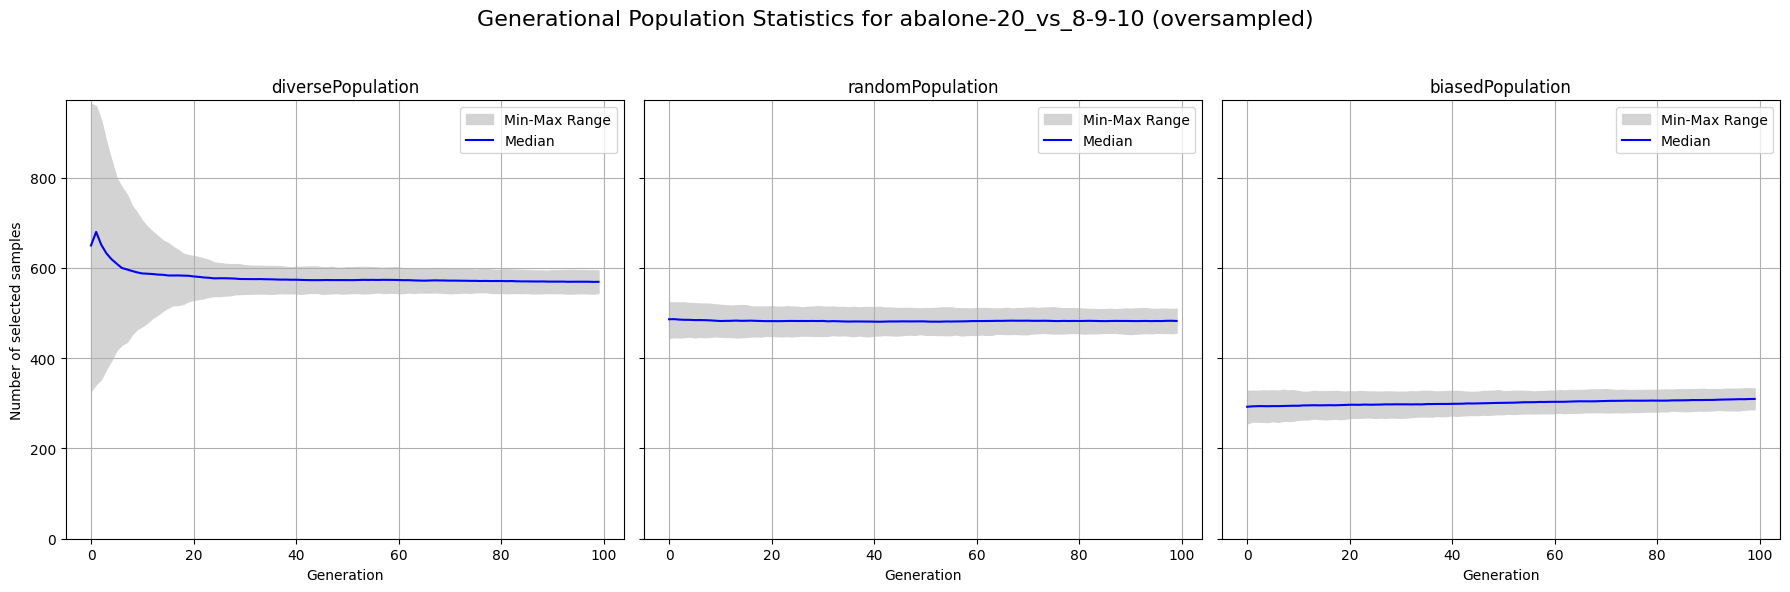

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

# Define your parameters
target_name = "abalone-20_vs_8-9-10"
sample_types = ["diversePopulation", "randomPopulation", "biasedPopulation"]  # Replace with your actual sample types

# Create a figure with 3 subplots arranged horizontally
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle(f'Generational Population Statistics for {target_name} (oversampled)', fontsize=16)

for ax, sample_type in zip(axes, sample_types):
	# Construct the dataset key and file path
	ls1 = []
	ls2 = []
	ls3 = []
	
	for iter_num in datakey_mappings[dataset_name]:
		dataset_key = f"{iter_num}_{target_name}"
		file_path = f'results/{dataset_key} {sample_type} overSample.pickle'

		# Check if the file exists
		if not os.path.exists(file_path):
			print(f"File not found: {file_path}")
			continue

		# Load the result from the pickle file
		with open(file_path, "rb") as fh:
			result = pickle.load(fh)

		# Initialize lists to store statistics
		mins = []
		maxs = []
		medians = []

		# Iterate over each generation in the result history
		for generation in result.history:
			generation_vals = [np.sum(individual.X) for individual in generation.pop]
			total_samples = generation.pop[0].X.shape[0]  # Assuming all individuals have the same shape

			# Compute statistics
			mins.append(np.min(generation_vals))
			medians.append(np.median(generation_vals))
			maxs.append(np.max(generation_vals))

		ls1.append(mins)
		ls2.append(medians)
		ls3.append(maxs)
	
	
	mins = np.mean(ls1, axis=0)
	medians = np.mean(ls2, axis=0)
	maxs = np.mean(ls3, axis=0)
	
	# Plot the statistics on the current subplot
	generations = np.arange(len(medians))
	ax.fill_between(generations, mins, maxs, color='lightgray', label='Min-Max Range')
	ax.plot(generations, medians, color='blue', label='Median')
	ax.set_title(f'{sample_type}')
	ax.set_xlabel('Generation')
	ax.set_ylim(0, total_samples)
	ax.grid(True)
	if ax == axes[0]:
		ax.set_ylabel('Number of selected samples')
	ax.legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


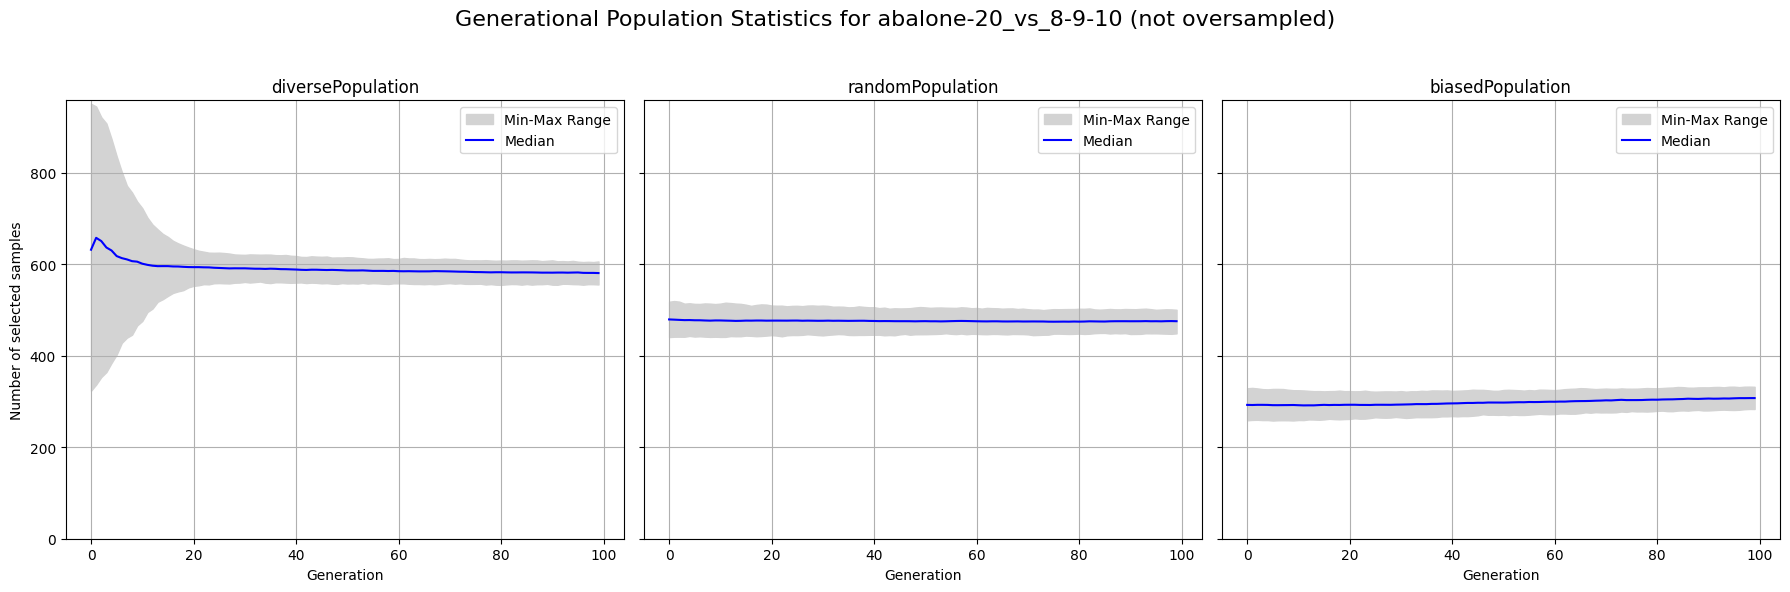

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

# Define your parameters
target_name = "abalone-20_vs_8-9-10"
sample_types = ["diversePopulation", "randomPopulation", "biasedPopulation"]  # Replace with your actual sample types

# Create a figure with 3 subplots arranged horizontally
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle(f'Generational Population Statistics for {target_name} (not oversampled)', fontsize=16)

for ax, sample_type in zip(axes, sample_types):
	# Construct the dataset key and file path
	ls1 = []
	ls2 = []
	ls3 = []
	
	for iter_num in datakey_mappings[dataset_name]:
		dataset_key = f"{iter_num}_{target_name}"
		file_path = f'results/{dataset_key} {sample_type}.pickle'

		# Check if the file exists
		if not os.path.exists(file_path):
			print(f"File not found: {file_path}")
			continue

		# Load the result from the pickle file
		with open(file_path, "rb") as fh:
			result = pickle.load(fh)

		# Initialize lists to store statistics
		mins = []
		maxs = []
		medians = []

		# Iterate over each generation in the result history
		for generation in result.history:
			generation_vals = [np.sum(individual.X) for individual in generation.pop]
			total_samples = generation.pop[0].X.shape[0]  # Assuming all individuals have the same shape

			# Compute statistics
			mins.append(np.min(generation_vals))
			medians.append(np.median(generation_vals))
			maxs.append(np.max(generation_vals))

		ls1.append(mins)
		ls2.append(medians)
		ls3.append(maxs)
	
	
	mins = np.mean(ls1, axis=0)
	medians = np.mean(ls2, axis=0)
	maxs = np.mean(ls3, axis=0)
	
	# Plot the statistics on the current subplot
	generations = np.arange(len(medians))
	ax.fill_between(generations, mins, maxs, color='lightgray', label='Min-Max Range')
	ax.plot(generations, medians, color='blue', label='Median')
	ax.set_title(f'{sample_type}')
	ax.set_xlabel('Generation')
	ax.set_ylim(0, total_samples)
	ax.grid(True)
	if ax == axes[0]:
		ax.set_ylabel('Number of selected samples')
	ax.legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


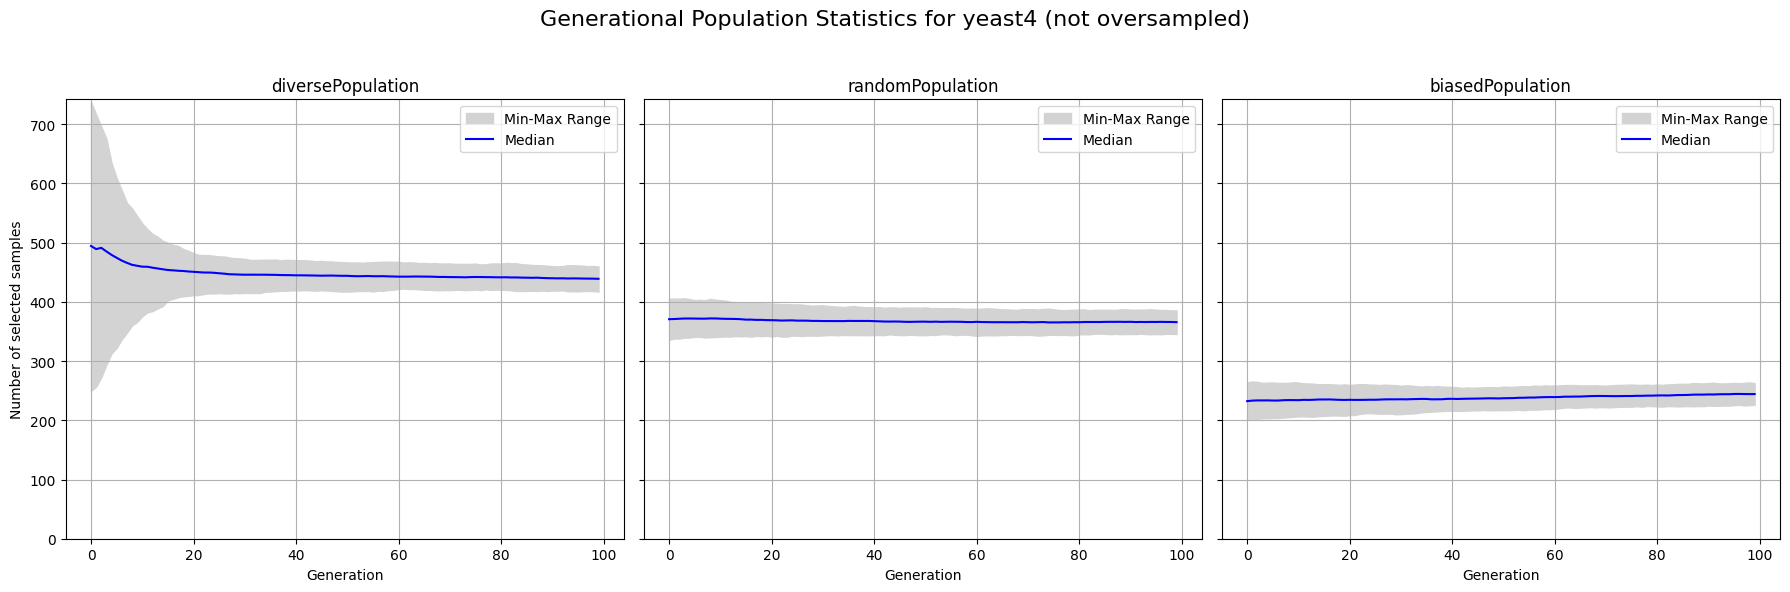

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

# Define your parameters
target_name = "yeast4"
sample_types = ["diversePopulation", "randomPopulation", "biasedPopulation"]  # Replace with your actual sample types

# Create a figure with 3 subplots arranged horizontally
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle(f'Generational Population Statistics for {target_name} (not oversampled)', fontsize=16)

for ax, sample_type in zip(axes, sample_types):
	# Construct the dataset key and file path
	ls1 = []
	ls2 = []
	ls3 = []
	
	for iter_num in datakey_mappings[dataset_name]:
		dataset_key = f"{iter_num}_{target_name}"
		file_path = f'results/{dataset_key} {sample_type}.pickle'

		# Check if the file exists
		if not os.path.exists(file_path):
			print(f"File not found: {file_path}")
			continue

		# Load the result from the pickle file
		with open(file_path, "rb") as fh:
			result = pickle.load(fh)

		# Initialize lists to store statistics
		mins = []
		maxs = []
		medians = []

		# Iterate over each generation in the result history
		for generation in result.history:
			generation_vals = [np.sum(individual.X) for individual in generation.pop]
			total_samples = generation.pop[0].X.shape[0]  # Assuming all individuals have the same shape

			# Compute statistics
			mins.append(np.min(generation_vals))
			medians.append(np.median(generation_vals))
			maxs.append(np.max(generation_vals))

		ls1.append(mins)
		ls2.append(medians)
		ls3.append(maxs)
	
	
	mins = np.mean(ls1, axis=0)
	medians = np.mean(ls2, axis=0)
	maxs = np.mean(ls3, axis=0)
	
	# Plot the statistics on the current subplot
	generations = np.arange(len(medians))
	ax.fill_between(generations, mins, maxs, color='lightgray', label='Min-Max Range')
	ax.plot(generations, medians, color='blue', label='Median')
	ax.set_title(f'{sample_type}')
	ax.set_xlabel('Generation')
	ax.set_ylim(0, total_samples)
	ax.grid(True)
	if ax == axes[0]:
		ax.set_ylabel('Number of selected samples')
	ax.legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


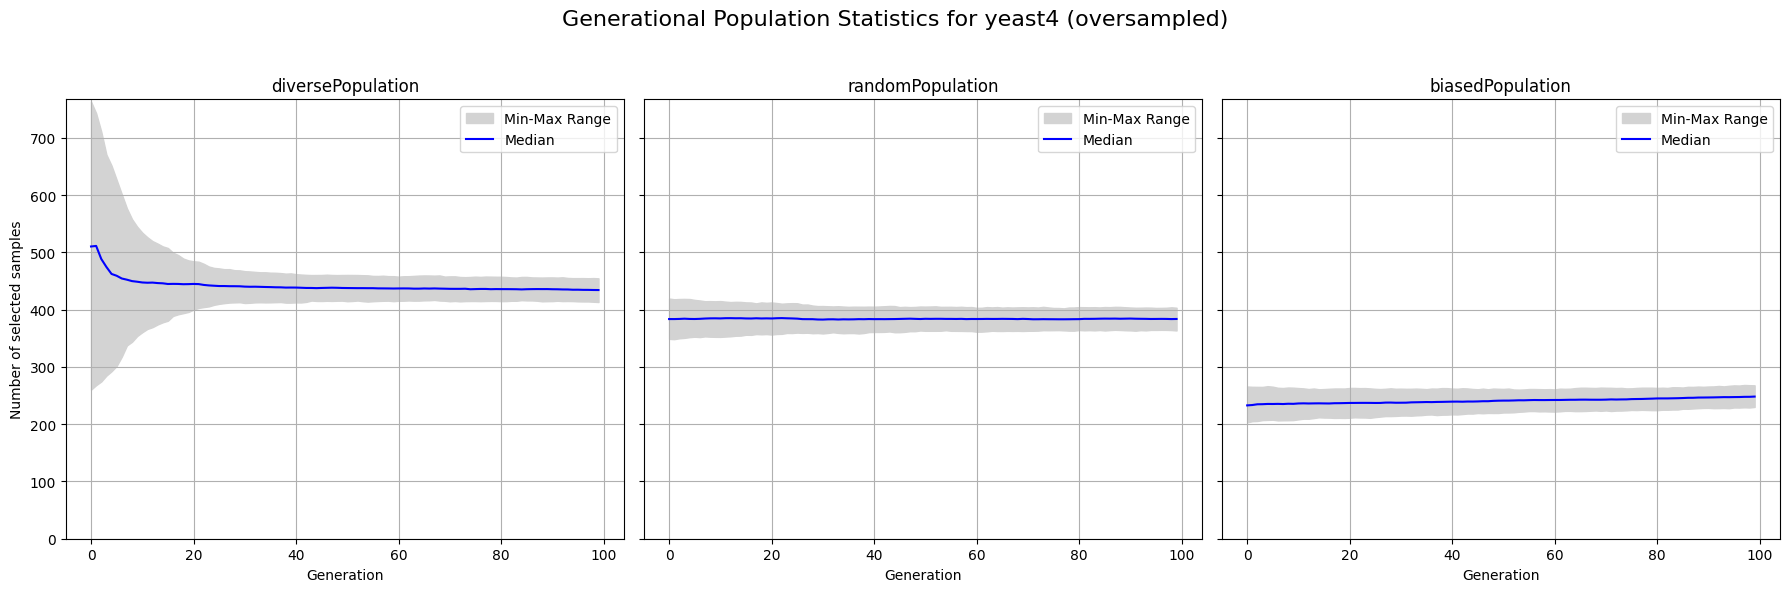

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

# Define your parameters
target_name = "yeast4"
sample_types = ["diversePopulation", "randomPopulation", "biasedPopulation"]  # Replace with your actual sample types

# Create a figure with 3 subplots arranged horizontally
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle(f'Generational Population Statistics for {target_name} (oversampled)', fontsize=16)

for ax, sample_type in zip(axes, sample_types):
	# Construct the dataset key and file path
	ls1 = []
	ls2 = []
	ls3 = []
	
	for iter_num in datakey_mappings[dataset_name]:
		dataset_key = f"{iter_num}_{target_name}"
		file_path = f'results/{dataset_key} {sample_type} overSample.pickle'

		# Check if the file exists
		if not os.path.exists(file_path):
			print(f"File not found: {file_path}")
			continue

		# Load the result from the pickle file
		with open(file_path, "rb") as fh:
			result = pickle.load(fh)

		# Initialize lists to store statistics
		mins = []
		maxs = []
		medians = []

		# Iterate over each generation in the result history
		for generation in result.history:
			generation_vals = [np.sum(individual.X) for individual in generation.pop]
			total_samples = generation.pop[0].X.shape[0]  # Assuming all individuals have the same shape

			# Compute statistics
			mins.append(np.min(generation_vals))
			medians.append(np.median(generation_vals))
			maxs.append(np.max(generation_vals))

		ls1.append(mins)
		ls2.append(medians)
		ls3.append(maxs)
	
	
	mins = np.mean(ls1, axis=0)
	medians = np.mean(ls2, axis=0)
	maxs = np.mean(ls3, axis=0)
	
	# Plot the statistics on the current subplot
	generations = np.arange(len(medians))
	ax.fill_between(generations, mins, maxs, color='lightgray', label='Min-Max Range')
	ax.plot(generations, medians, color='blue', label='Median')
	ax.set_title(f'{sample_type}')
	ax.set_xlabel('Generation')
	ax.set_ylim(0, total_samples)
	ax.grid(True)
	if ax == axes[0]:
		ax.set_ylabel('Number of selected samples')
	ax.legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()
